# ChestX-ray 14 Data Preprocessing, Model Training, and Model Testing - Cardiomegaly Only
## Madison Moffat-Wild and Rachel Woodside

### https://paperswithcode.com/dataset/chestx-ray14
### https://www.kaggle.com/datasets/nih-chest-xrays/data/data
### https://www.kaggle.com/code/rerere/nih-chest-x-rays-deep-convolutional-network/notebook

Resources:
https://machinelearningmastery.com/best-practices-for-preparing-and-augmenting-image-data-for-convolutional-neural-networks/

## Set up

### Import Libraries

In [32]:
import pathlib
import itertools
import glob
import PIL

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow_addons as tfa

from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LayerNormalization, Input, LSTM, GRU, TimeDistributed
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D, Dense, Softmax, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

### Initialize Path to Data

In [6]:
# Store path to data folder
#data_folder = "~/ChestXray14Data/"
data_folder = "data/"
data_dir = pathlib.Path(data_folder).with_suffix('')

### Read in Data Frames

In [7]:
data = pd.read_csv(data_folder+'Data_Entry_2017.csv')
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN


## Data Preprocessing

### Rename Columns

In [8]:
data = data.rename(columns={
    "OriginalImagePixelSpacing[x": "OriginalPixelSpacingX",
    "y]": "OriginalPixelSpacingY",
    "OriginalImage[Width": "OriginalImageWidth",
    "Height]": "OriginalImageHeight"
})
data.drop("Unnamed: 11", axis=1, inplace=True)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,OriginalPixelSpacingY
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143


In [9]:
# Replace age values > 100 with 100
data['Patient Age'].where(data['Patient Age'] <= 100, 100, inplace=True)

### One-Hot Encode Multilabel Data

In [10]:
# https://www.kaggle.com/code/ashishmundu/nih-chest-x-rays-deep-convolutional-network
# Generate one-hot encoding for the labels
# Get all the labels
unique_labels = pd.Series(itertools.chain.from_iterable(data["Finding Labels"].apply(lambda x : x.split('|')))).unique()

# Initialize an empty matrix 
one_hot_encodings = pd.DataFrame(0.0, index=np.arange(len(data)), columns=unique_labels)

# For each row, we get the associated labels and set a 1 to the new corresponding column label 
for index, row in data.iterrows():
    labels = row["Finding Labels"].split('|')
    for label in labels:
        one_hot_encodings.iloc[index][label] = 1.0

one_hot_encodings.head()

,Cardiomegaly,Emphysema,Effusion,No Finding,Hernia,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
data = pd.concat([data, one_hot_encodings], axis=1)
data.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Isolate "Cardiomegaly" Data

In [12]:
# Count cardiomegaly instances
cardiomegaly_count = data[data["Cardiomegaly"] == 1]["Cardiomegaly"].count()
sample_size = int(cardiomegaly_count/(len(unique_labels)-1))
print(f'Instances of cardiomegaly: {cardiomegaly_count}')
print(f'Number of samples to take from each other category: {sample_size}')

Instances of cardiomegaly: 2776
Number of samples to take from each other category: 198


### Sample Different Categories of "No Cardiomegaly" Data

In [13]:
# Generate samples of appropriate size from each other category
no_cardiomegaly = data[data["Cardiomegaly"] == 0]

emphysema_sample = no_cardiomegaly[no_cardiomegaly["Emphysema"] == 1].sample(sample_size, random_state=101)
effusion_sample = no_cardiomegaly[no_cardiomegaly["Effusion"] == 1].sample(sample_size, random_state=101)
no_finding_sample = no_cardiomegaly[no_cardiomegaly["No Finding"] == 1].sample(sample_size, random_state=101)
hernia_sample = no_cardiomegaly[no_cardiomegaly["Hernia"] == 1].sample(sample_size, random_state=101)
infiltration_sample = no_cardiomegaly[no_cardiomegaly["Infiltration"] == 1].sample(sample_size, random_state=101)
mass_sample = no_cardiomegaly[no_cardiomegaly["Mass"] == 1].sample(sample_size, random_state=101)
nodule_sample = no_cardiomegaly[no_cardiomegaly["Nodule"] == 1].sample(sample_size, random_state=101)
atelectasis_sample = no_cardiomegaly[no_cardiomegaly["Atelectasis"] == 1].sample(sample_size, random_state=101)
pneumothorax_sample = no_cardiomegaly[no_cardiomegaly["Pneumothorax"] == 1].sample(sample_size, random_state=101)
pleural_thickening_sample = no_cardiomegaly[no_cardiomegaly["Pleural_Thickening"] == 1].sample(sample_size, random_state=101)
pneumonia_sample = no_cardiomegaly[no_cardiomegaly["Pneumonia"] == 1].sample(sample_size, random_state=101)
fibrosis_sample = no_cardiomegaly[no_cardiomegaly["Fibrosis"] == 1].sample(sample_size, random_state=101)
edema_sample = no_cardiomegaly[no_cardiomegaly["Edema"] == 1].sample(sample_size, random_state=101)
consolidation_sample = no_cardiomegaly[no_cardiomegaly["Consolidation"] == 1].sample(sample_size, random_state=101)

# Concatenate all samples together
no_cardiomegaly_sample = pd.concat([emphysema_sample, effusion_sample, no_finding_sample, hernia_sample, 
                   infiltration_sample, mass_sample, nodule_sample, atelectasis_sample, 
                   pneumothorax_sample, pleural_thickening_sample, pneumonia_sample, 
                   fibrosis_sample, edema_sample, consolidation_sample])
no_cardiomegaly_sample.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
58105,00014379_004.png,Emphysema|Pleural_Thickening,4,14379,62,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
105391,00028317_007.png,Emphysema|Pneumothorax,7,28317,53,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
32338,00008468_012.png,Emphysema,12,8468,10,F,AP,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
58106,00014379_005.png,Emphysema|Infiltration|Pleural_Thickening,5,14379,62,M,AP,3056,2544,0.139,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
85663,00021127_005.png,Emphysema,5,21127,66,M,AP,3056,2544,0.139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Manage data leakage between "no cardiomegaly" instances due to multilabel data
# (e.g. a picture with "Atelectasis|Hernia|Infiltration|Mass|Nodule|Pneumothorax" gets sampled for both Atalectasis and Pneumothorax)
emphysema_sample_set = set(emphysema_sample["Patient ID"].values)
effusion_sample_set = set(effusion_sample["Patient ID"].values)
no_finding_sample_set = set(no_finding_sample["Patient ID"].values)
hernia_sample_set = set(hernia_sample["Patient ID"].values)
infiltration_sample_set = set(infiltration_sample["Patient ID"].values)
mass_sample_set = set(mass_sample["Patient ID"].values)
nodule_sample_set = set(nodule_sample["Patient ID"].values)
atelectasis_sample_set = set(atelectasis_sample["Patient ID"].values)
pneumothorax_sample_set = set(pneumothorax_sample["Patient ID"].values)
pleural_thickening_sample_set = set(pleural_thickening_sample["Patient ID"].values)
pneumonia_sample_set = set(pneumonia_sample["Patient ID"].values)
fibrosis_sample_set = set(fibrosis_sample["Patient ID"].values)
edema_sample_set = set(edema_sample["Patient ID"].values)
consolidation_sample_set = set(consolidation_sample["Patient ID"].values)

In [15]:
# https://stackoverflow.com/questions/27369373/pairwise-set-intersection-in-python
sample_sets = [emphysema_sample_set, effusion_sample_set, no_finding_sample_set, hernia_sample_set, 
                   infiltration_sample_set, mass_sample_set, nodule_sample_set, atelectasis_sample_set, 
                   pneumothorax_sample_set, pleural_thickening_sample_set, pneumonia_sample_set, 
                   fibrosis_sample_set, edema_sample_set, consolidation_sample_set]

set_combinations = itertools.combinations(range(len(sample_sets)), 2)

set_intersection_fn = lambda a, b: sample_sets[a].intersection(sample_sets[b])
leakage_patient_sets = [set_intersection_fn(*combo) for combo in set_combinations]
leakage_patient = set.union(*leakage_patient_sets)
print(f'Number of patient IDs present in multiple "no cardiomegaly" samples: {len(leakage_patient)}')

Number of patient IDs present in multiple "no cardiomegaly" samples: 361


In [16]:
# Remove data leakage from "no cardiomegaly" sample
print(f'Size of "No Cardiomegaly" Sample before data leakage removal: {len(no_cardiomegaly_sample)}')
no_cardiomegaly_sample = no_cardiomegaly_sample[~no_cardiomegaly_sample["Patient ID"].isin(leakage_patient)]
print(f'Size of "No Cardiomegaly" Sample after data leakage removal: {len(no_cardiomegaly_sample)}')

Size of "No Cardiomegaly" Sample before data leakage removal: 2772
Size of "No Cardiomegaly" Sample after data leakage removal: 1791


In [17]:
cardiomegaly_sample = data[data["Cardiomegaly"] == 1].sample(len(no_cardiomegaly_sample))
print(f'Size of "Cardiomegaly" Sample after data leakage removal: {len(cardiomegaly_sample)}')

Size of "Cardiomegaly" Sample after data leakage removal: 1791


In [ ]:
# TODO: Visualize the proportion of each "No Cardiomegaly" category in the dataset at this point?

### Build New Balanced Dataset from Samples of "Cardiomegaly" and "No Cardiomegaly" Data

In [18]:
# Combine cardiomegaly positive and cardiomegaly negative data
cardiomegaly_data = pd.concat([cardiomegaly_sample, no_cardiomegaly_sample])
print(f'Final Size of Sampled Cardiomegaly Dataset: {len(cardiomegaly_data)}')
cardiomegaly_data.head()

Final Size of Sampled Cardiomegaly Dataset: 3582


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,...,Infiltration,Mass,Nodule,Atelectasis,Pneumothorax,Pleural_Thickening,Pneumonia,Fibrosis,Edema,Consolidation
7239,00001911_015.png,Atelectasis|Cardiomegaly|Effusion,15,1911,63,F,PA,2310,2569,0.143,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
61928,00015314_003.png,Cardiomegaly|Effusion,3,15314,53,F,PA,2992,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4879,00001301_043.png,Atelectasis|Cardiomegaly|Effusion|Mass,43,1301,57,F,AP,2500,2048,0.168,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
28933,00007551_016.png,Cardiomegaly,16,7551,27,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18419,00004893_073.png,Cardiomegaly,73,4893,34,M,PA,2662,2913,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
# Clean up and remove columns that are no longer relevant
cardiomegaly_data
cardiomegaly_data = cardiomegaly_data.drop(['Finding Labels','Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], axis=1)
cardiomegaly_data.head()

,Image Index,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalPixelSpacingX,OriginalPixelSpacingY,Cardiomegaly
7239,00001911_015.png,15,1911,63,F,PA,2310,2569,0.143,0.143,1.0
61928,00015314_003.png,3,15314,53,F,PA,2992,2991,0.143,0.143,1.0
4879,00001301_043.png,43,1301,57,F,AP,2500,2048,0.168,0.168,1.0
28933,00007551_016.png,16,7551,27,M,AP,2500,2048,0.168,0.168,1.0
18419,00004893_073.png,73,4893,34,M,PA,2662,2913,0.143,0.143,1.0


In [ ]:
# TODO: Visualize some example images?

## Test-Train Split

In [20]:
# Generate train and test sets
cardiomegaly_data_train, cardiomegaly_data_test = train_test_split(cardiomegaly_data, test_size=0.3, random_state=101)
print(f"Size of training set: {len(cardiomegaly_data_train)}\nSize of testing set: {len(cardiomegaly_data_test)}")

Size of training set: 2507
Size of testing set: 1075


In [21]:
# Check for patient ID overlap (i.e. data leakage) between train and test sets
patient_train = set(cardiomegaly_data_train["Patient ID"].values)
patient_test  = set(cardiomegaly_data_test["Patient ID"].values)

leakage_patient = patient_train.intersection(patient_test)
print(f'Instances with patient ID in both training and test data: {len(leakage_patient)}')

234


In [22]:
# Determine extent of data leakage
train_without_leakage = cardiomegaly_data_train[~cardiomegaly_data_train["Patient ID"].isin(leakage_patient)]

print("Training Set")
print(f"Proportion of Data Leakage: {len(train_without_leakage) / len(cardiomegaly_data_train)}")
print(f"Instances without Leakage Removal: {len(cardiomegaly_data_train)}")
print(f"Instances with Leakage Removal: {len(train_without_leakage)}")

print()
print("Test")
test_without_leakage = cardiomegaly_data_test[~cardiomegaly_data_test["Patient ID"].isin(leakage_patient)]
print(f"Proportion of Data Leakage: {len(test_without_leakage) / len(cardiomegaly_data_test)}")
print(f"Instances without Leakage Removal: {len(cardiomegaly_data_test)}")
print(f"Instances with Leakage Removal: {len(test_without_leakage)}")

Training Set
Proportion of Data Leakage: 0.7738332668528122
Instances without Leakage Removal: 2507
Instances with Leakage Removal: 1940

Test
Proportion of Data Leakage: 0.6586046511627907
Instances without Leakage Removal: 1075
Instances with Leakage Removal: 708


In [23]:
# Remvove leakage in the test data
cardiomegaly_data_test = test_without_leakage

## Model Training

In [24]:
# Define model training parameters
num_labels = 1
batch_size = 32

In [25]:
# Split further to obtain validation data
X_train, X_valid = train_test_split(cardiomegaly_data_train, test_size=0.2, random_state=101)

### Define and Create Data Generators

In [39]:
class ChestImagesDataset(tf.keras.utils.Sequence):
    def __init__(self, df, input_folder, batch_size = 32, transform = None, training = True, shuffle = True):
        self.df           = df
        self.input_folder = input_folder
        self.batch_size   = batch_size
        self.transform    = transform
        self.training     = training
        self.shuffle      = shuffle
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac = 1).reset_index(drop = True)
    
    def __len__(self):
        return np.ceil(len(self.df) / self.batch_size).astype(int)
    
    def __getitem__(self, index):
        batch = self.df[index * self.batch_size : (index + 1) * self.batch_size]
        
        images = []
        
        for filename in batch["Image Index"]:
            path = glob.glob(self.input_folder + "*/*/" + filename)[0]
            image = PIL.Image.open(path).convert('RGB')
            image = np.array(image)
            
            image = tf.image.resize(image, size=(224,224))
            image = tf.cast(image, dtype = tf.float32)
            
            images.append(image)
        
        images = np.array(images)
        
        if self.training:
            return images, np.array(batch["Cardiomegaly"].values)
        else: 
            return images
    
# Create the training and validation data generators
train_generator = ChestImagesDataset(X_train, data_folder, batch_size=batch_size, transform=None, shuffle=True)
valid_generator = ChestImagesDataset(X_valid, data_folder, batch_size=batch_size, transform=None, shuffle=True)

### Define and Create Model

In [40]:
def create_VGG19_model():
    inputs = Input(shape=(224, 224, 3))
    model = tf.keras.applications.VGG19(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        pooling=None,
        classifier_activation="sigmoid"
    )
    model.trainable = False # Freeze the layer
    
    # Rebuild top
    x = GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = BatchNormalization()(x)

    x = Dropout(0.2, name="top_dropout")(x)
    outputs = Dense(num_labels, activation="sigmoid", name="pred")(x)
    
    # Compile
    model = tf.keras.Model(inputs, outputs, name="VGG19")
    
    # Note : Possibility to assign a learning rate.
    model.compile(optimizer=Adam(), 
                  loss = tf.keras.losses.BinaryCrossentropy(),
                  metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Recall(),
        tfa.metrics.F1Score(num_classes = num_labels, threshold=0.5),
        tf.keras.metrics.AUC()
    ])
    
    return model

model = create_VGG19_model()

### Train Model

In [41]:
history = model.fit(train_generator, validation_data=valid_generator, epochs=8, batch_size=batch_size)

Epoch 1/8
63/63 [==============================] - 876s 14s/step - loss: 0.8215 - binary_accuracy: 0.5342 - recall_4: 0.5210 - f1_score: 0.5210 - auc_4: 0.5543 - val_loss: 0.8449 - val_binary_accuracy: 0.5618 - val_recall_4: 0.3000 - val_f1_score: 0.4149 - val_auc_4: 0.6265
Epoch 2/8
63/63 [==============================] - 913s 15s/step - loss: 0.6979 - binary_accuracy: 0.6015 - recall_4: 0.5877 - f1_score: 0.5892 - auc_4: 0.6534 - val_loss: 0.6894 - val_binary_accuracy: 0.5976 - val_recall_4: 0.4308 - val_f1_score: 0.5258 - val_auc_4: 0.6859
Epoch 3/8
63/63 [==============================] - 706s 11s/step - loss: 0.6472 - binary_accuracy: 0.6479 - recall_4: 0.6195 - f1_score: 0.6311 - auc_4: 0.7063 - val_loss: 0.6327 - val_binary_accuracy: 0.6315 - val_recall_4: 0.5615 - val_f1_score: 0.6122 - val_auc_4: 0.7102
Epoch 4/8
63/63 [==============================] - 524s 8s/step - loss: 0.6038 - binary_accuracy: 0.6778 - recall_4: 0.6759 - f1_score: 0.6711 - auc_4: 0.7436 - val_loss: 0.61

### Save Model

In [42]:
model.save("2023-12-01_cardiomegaly_VGG19_trial_model")

INFO:tensorflow:Assets written to: 2023-12-01_cardiomegaly_VGG19_trial_model\assets


INFO:tensorflow:Assets written to: 2023-12-01_cardiomegaly_VGG19_trial_model\assets


## Evaluate Model Performance on Validation Data

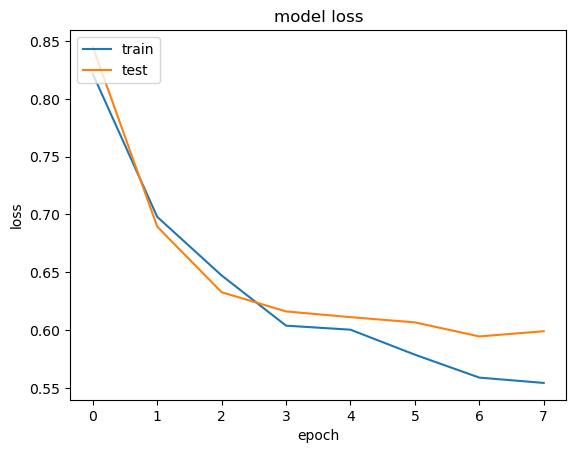

In [43]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

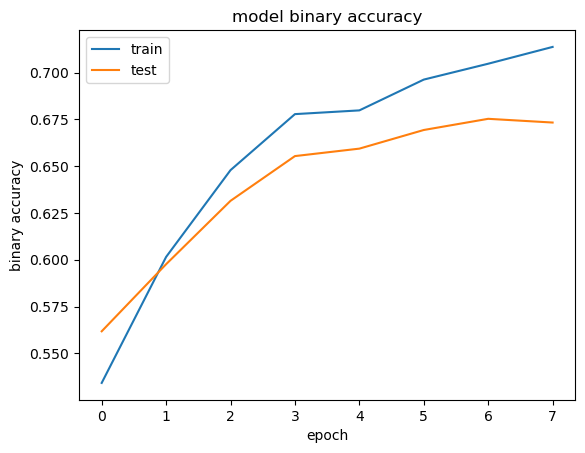

In [45]:
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])

plt.title('model binary accuracy')
plt.ylabel('binary accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

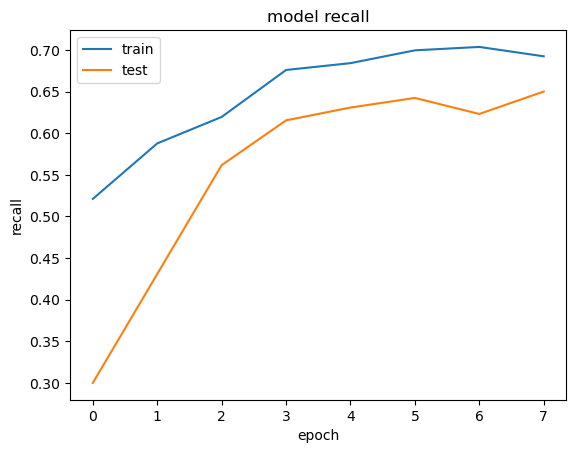

In [47]:
plt.plot(history.history['recall_4'])
plt.plot(history.history['val_recall_4'])

plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

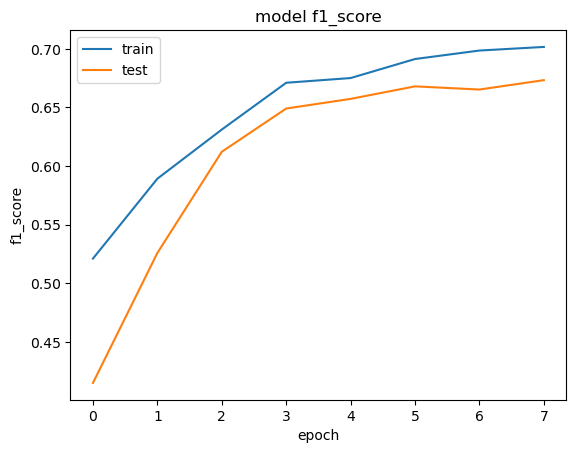

In [48]:
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])

plt.title('model f1_score')
plt.ylabel('f1_score')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

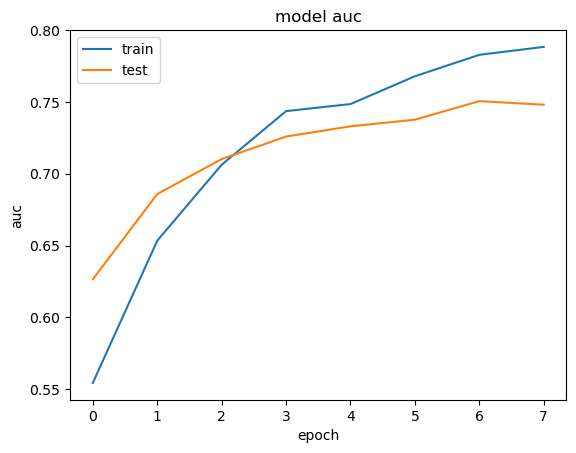

In [49]:
plt.plot(history.history['auc_4'])
plt.plot(history.history['val_auc_4'])

plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Model Testing

In [51]:
# TODO: Update this whole section to work with cardiomegaly only model

### Load and View Model

In [25]:
# Load desired model
model = keras.models.load_model("2023-11-26_VGG19_model")

In [26]:
model.summary()

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)      

### Create Test Data Generator

In [29]:
test_generator = ChestImagesDataset(dataEntry_test, data_folder, batch_size=batch_size, transform=None, training=False, shuffle=False)

193/193 [==============================] - 2567s 13s/step


### Generate Predictions

In [30]:
predictions = model.predict(test_generator)
predictions

array([[0.79042625, 0.20458555, 0.26078647, ..., 0.44531333, 0.0414209 ,
        0.17021376],
       [0.02404059, 0.9265888 , 0.6882352 , ..., 0.7549929 , 0.05709773,
        0.23497593],
       [0.2929569 , 0.5437398 , 0.32312417, ..., 0.49077258, 0.04590777,
        0.26591033],
       ...,
       [0.0457311 , 0.23270394, 0.02862629, ..., 0.35899484, 0.09484279,
        0.07218479],
       [0.25708973, 0.47961923, 0.33637312, ..., 0.31295988, 0.07704621,
        0.26209453],
       [0.56839365, 0.52594733, 0.859438  , ..., 0.5595214 , 0.29383954,
        0.6910809 ]], dtype=float32)

### Evaluate ROC

In [32]:
roc_auc_score(dataEntry_test[uniqueLabels].values, predictions)

0.7545953628118526

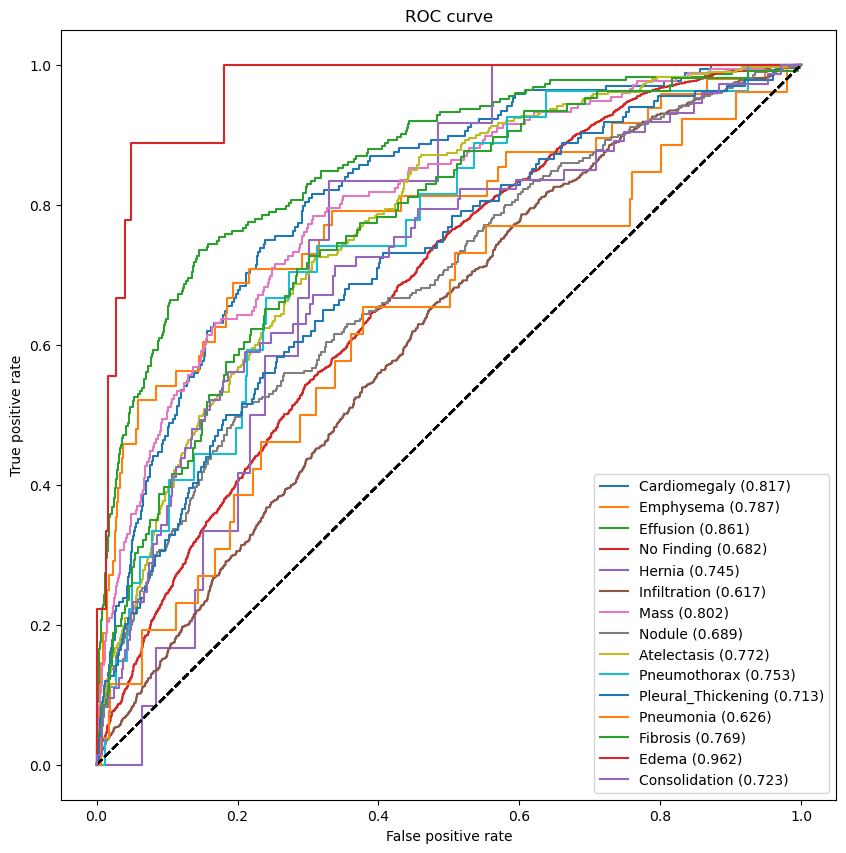

[0.8174454141529754,
 0.7870336278841434,
 0.8611655868879408,
 0.6821365301169067,
 0.7451331272707554,
 0.6170709034528783,
 0.8023348350629814,
 0.6886826034728905,
 0.7716001765895433,
 0.752500543596434,
 0.7132086455688363,
 0.6264972594664426,
 0.7689840372308758,
 0.9616802168021681,
 0.723456934622016]

In [35]:
def get_roc_curve(labels, predicted_vals, real_vals):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = real_vals[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf,
                     label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve')
            plt.legend(loc='best')
        except:
            print(
                f"Error in generating ROC curve for {labels[i]}. "
                f"Dataset lacks enough examples."
            )
    plt.show()
    return auc_roc_vals


get_roc_curve(list(uniqueLabels), predictions, dataEntry_test[uniqueLabels].values)

In [38]:
from sklearn.metrics import multilabel_confusion_matrix

In [45]:
y_pred = np.argmax(predictions, axis=1)
y_pred

array([ 0,  1, 10, ...,  3,  3,  2], dtype=int64)

In [48]:
y_test = np.argmax(dataEntry_test[uniqueLabels].to_numpy(), axis=1)
y_test

array([ 8,  2, 10, ...,  7,  3,  2], dtype=int64)

In [53]:
# https://stackoverflow.com/questions/48987959/classification-metrics-cant-handle-a-mix-of-continuous-multioutput-and-multi-la
conf_mat = multilabel_confusion_matrix(y_test, y_pred)
conf_mat

array([[[5528,  463],
        [ 107,   61]],

       [[6001,  115],
        [  29,   14]],

       [[5883,   96],
        [ 128,   52]],

       [[1163,  545],
        [1886, 2565]],

       [[5634,  514],
        [  10,    1]],

       [[5449,   73],
        [ 619,   18]],

       [[5961,   74],
        [ 117,    7]],

       [[5847,  142],
        [ 156,   14]],

       [[5821,  150],
        [ 168,   20]],

       [[6044,  103],
        [  12,    0]],

       [[5886,  196],
        [  72,    5]],

       [[6085,   59],
        [  15,    0]],

       [[5338,  769],
        [  34,   18]],

       [[6090,   67],
        [   1,    1]],

       [[6113,   17],
        [  29,    0]]], dtype=int64)

In [62]:
from sklearn.metrics import classification_report

In [67]:
uniqueLabels

array(['Cardiomegaly', 'Emphysema', 'Effusion', 'No Finding', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax',
       'Pleural_Thickening', 'Pneumonia', 'Fibrosis', 'Edema',
       'Consolidation'], dtype=object)

In [82]:
indices = list(range(0, len(uniqueLabels)))
indices = list(map(str, indices))
indices

['0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 '10',
 '11',
 '12',
 '13',
 '14']

In [83]:
labelDict = dict(zip(indices, uniqueLabels))
labelDict

{'0': 'Cardiomegaly',
 '1': 'Emphysema',
 '2': 'Effusion',
 '3': 'No Finding',
 '4': 'Hernia',
 '5': 'Infiltration',
 '6': 'Mass',
 '7': 'Nodule',
 '8': 'Atelectasis',
 '9': 'Pneumothorax',
 '10': 'Pleural_Thickening',
 '11': 'Pneumonia',
 '12': 'Fibrosis',
 '13': 'Edema',
 '14': 'Consolidation'}

In [77]:
#[type(k) for k in labelDict.keys()]

[int, int, int, int, int, int, int, int, int, int, int, int, int, int, int]

In [84]:
class_report_dict = classification_report(y_test, y_pred, output_dict=True)

In [88]:
class_report_dict = {k: class_report_dict.get(k, None) for k in indices}
class_report_dict.keys()

dict_keys(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14'])

In [79]:
#[type(k) for k in class_report_dict.keys()]

[str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str,
 str]

In [89]:
#https://stackoverflow.com/questions/17933168/replace-dictionary-keys-strings-in-python
labelled_class_report = {labelDict[k]: v for k, v in class_report_dict.items()}

In [90]:
labelled_class_report

{'Cardiomegaly': {'precision': 0.11641221374045801,
  'recall': 0.3630952380952381,
  'f1-score': 0.17630057803468208,
  'support': 168.0},
 'Emphysema': {'precision': 0.10852713178294573,
  'recall': 0.32558139534883723,
  'f1-score': 0.16279069767441862,
  'support': 43.0},
 'Effusion': {'precision': 0.35135135135135137,
  'recall': 0.28888888888888886,
  'f1-score': 0.31707317073170727,
  'support': 180.0},
 'No Finding': {'precision': 0.8247588424437299,
  'recall': 0.5762749943832847,
  'f1-score': 0.6784816823171538,
  'support': 4451.0},
 'Hernia': {'precision': 0.001941747572815534,
  'recall': 0.09090909090909091,
  'f1-score': 0.0038022813688212923,
  'support': 11.0},
 'Infiltration': {'precision': 0.1978021978021978,
  'recall': 0.0282574568288854,
  'f1-score': 0.049450549450549455,
  'support': 637.0},
 'Mass': {'precision': 0.08641975308641975,
  'recall': 0.056451612903225805,
  'f1-score': 0.06829268292682926,
  'support': 124.0},
 'Nodule': {'precision': 0.08974358974